# AMEX DEFAULT

## Libraries and loading data 

In [1]:
# !pip install feature_engine

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from scipy.stats import zscore
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings("ignore")
#Generic libraryies
import random
import math
import itertools

#Time and monitoring libraries
import time
from tqdm import tqdm
import pyprind

#Visual libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import seaborn as sns

#Processing data
from sklearn.preprocessing import RobustScaler , MinMaxScaler , power_transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import MissingIndicator

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sys
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-parquet/test_data.parquet
/kaggle/input/amex-parquet/train_data.parquet


## Load data

In [3]:
categorical = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
target = "target"
dates = "S_2"

seed = 95

# We will use parquet format of the dataset created by @odins0n for some data exploration. Parquet is fater and save the dtypes of each columns when we read and write.
%time train = pd.read_parquet("/kaggle/input/amex-parquet/train_data.parquet")
print()
train.info()

CPU times: user 10.7 s, sys: 13.2 s, total: 23.9 s
Wall time: 40.5 s

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Columns: 191 entries, customer_ID to target
dtypes: float32(185), int64(2), object(4)
memory usage: 4.1+ GB


## Functions

In [4]:
def scaler(df, features , target = None):
    aux = power_transform(df[features].values)
    aux = pd.DataFrame(aux, columns = features)
    try:
        aux = pd.merge(aux, df[target], left_index=True, right_index=True)
        return aux
    except:
        return aux

In [5]:
def nansFeatPerc(features, data = train):
    #Return % nan columns
    return round(data[features].isna().mean().sort_values(ascending = False).to_frame().T *100,2)[data[features].isna().mean().sort_values(ascending = False).to_frame().T > 0].dropna(axis = 1)

In [6]:
def plotNansPer(features , data = train):
    plt.figure(figsize = (12,6))
    data[features].isna().mean().plot(kind='hist', bins=len(features))
    plt.title('Null Values in features' , fontsize=16)
    plt.xlabel('Percent of Null Values')
    plt.show()

In [7]:
def missingSW(df, features):
    imp = MissingIndicator()
    names = [ f"{j}M" for j in features ]
    df[names] = imp.fit_transform(df[features])
    for j in names:
        df[j] = df[j].apply(lambda x : 1 if x == True else 0)
    return df

In [8]:
def imputerLR(df, features, seed = 95):
    imp_mean = IterativeImputer(random_state=seed)
    names = [f"{x}MLr" for x in features]
    df[names] = imp_mean.fit_transform(scaler(df,features))
    return df

## Data

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

* D_* = Delinquency variables
* S_* = Spend variables
* P_* = Payment variables
* B_* = Balance variables
* R_* = Risk variables


With the following features beign categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [9]:
d_features = [c for c in train.columns if c.startswith('D_')]
s_features = [c for c in train.columns if c.startswith('S_')]
p_features = [c for c in train.columns if c.startswith('P_')]
b_features = [c for c in train.columns if c.startswith('B_')]
r_features = [c for c in train.columns if c.startswith('R_')]

print("We have {} Spend features.".format(len(s_features)))
print("We have {} Delinquency features.".format(len(d_features)))
print("We have {} Payment features.".format(len(p_features)))
print("We have {} Balance features.".format(len(b_features)))
print("We have {} Risk features.".format(len(r_features)))

We have 22 Spend features.
We have 96 Delinquency features.
We have 3 Payment features.
We have 40 Balance features.
We have 28 Risk features.


## EDA

### Target

In [10]:
train.groupby("target").count()["customer_ID"] *100 / len(train)

target
0    75.090279
1    24.909721
Name: customer_ID, dtype: float64

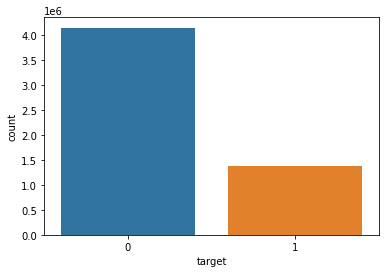

In [11]:
sns.countplot(train["target"])
plt.show()

In [12]:
len(train) , len(train.customer_ID.unique())

(5531451, 458913)

For each customer, we have more than 1 row, so we need analize the target for each date.

In [13]:
train[train.customer_ID ==  train.iloc[0].customer_ID ].iloc[:,:10]

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312
5,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,0.009857,0.009866
6,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-09-18,0.940705,0.002183,0.018859,1.008024,0.004509,0.103329,0.006603,0.000783
7,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-10-08,0.914767,0.003029,0.014324,1.000242,0.000263,0.108115,0.009527,0.007836
8,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-11-20,0.950845,0.009896,0.016888,1.003995,0.001789,0.102792,0.002519,0.009817
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0.001082,0.001930,1.007504,0.001772,0.100470,0.004626,0.006073


In [14]:
nulls = train.isna().sum().sort_values(ascending = False).to_frame().reset_index()
nulls["index"] = nulls["index"].apply(lambda x : x[0])
nullsByType = nulls.groupby("index").sum()

The 77% of nulls are in the Delinquency features.

In [15]:
nullsByType *100/nullsByType.sum()

,0
index,
B,12.031823
D,77.372196
P,0.216013
R,6.384412
S,3.995555
c,0.000000
t,0.000000


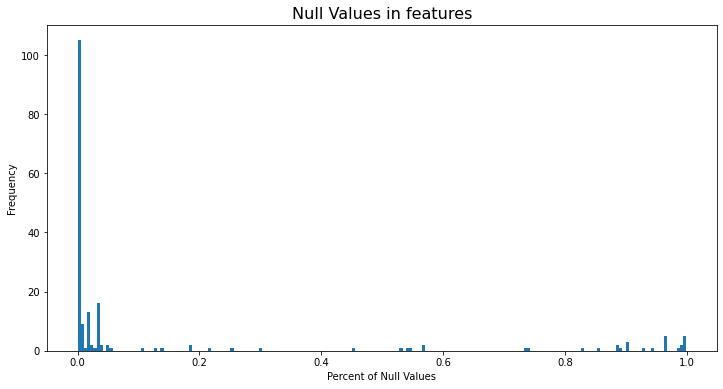

In [16]:
plotNansPer(train.columns)

### Spent features

Data types:

In [17]:
train[s_features + [target]].dtypes.to_frame().T

,S_2,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,target
0,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64


In [18]:
train[s_features + [target]]

,S_2,S_3,S_5,S_6,S_7,S_8,S_9,S_11,S_12,S_13,S_15,S_16,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,target
0,2017-03-09,0.124035,0.023381,0.008322,0.161345,0.922998,0.065728,0.401619,0.272008,0.515222,0.108271,0.002271,0.008033,0.005720,0.002537,0.009705,0.894090,0.135561,0.911191,0.974539,0.001243,0.676922,0
1,2017-04-07,0.126750,0.030599,0.002482,0.140951,0.919414,0.093935,0.406326,0.188970,0.509048,0.101018,0.009810,0.000760,0.007584,0.008427,0.009924,0.902135,0.136333,0.919876,0.975625,0.004561,0.822281,0
2,2017-05-28,0.123977,0.048367,0.000530,0.112229,1.001977,0.084757,0.406768,0.495308,0.679257,0.103239,0.009362,0.004056,0.005901,0.007327,0.008446,0.939654,0.134938,0.958699,0.974067,0.011736,0.853498,0
3,2017-06-13,0.117169,0.030063,0.000783,0.102838,0.704016,0.048382,0.405175,0.508670,0.515282,0.206394,0.004876,0.006969,0.002520,0.007053,0.006614,0.913205,0.140058,0.926341,0.975499,0.007571,0.844667,0
4,2017-07-16,0.117325,0.054221,0.006698,0.094311,0.917133,0.039259,0.487460,0.216507,0.507712,0.106020,0.007447,0.001770,0.000155,0.007728,0.005511,0.921026,0.131620,0.933479,0.978027,0.018200,0.811199,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531446,2017-11-05,0.090743,0.036700,0.000038,0.055695,0.705097,0.021471,0.483833,0.188514,0.511308,0.204409,0.008612,0.006024,0.000671,0.003172,0.004446,0.971546,0.132063,0.975162,0.970563,0.006208,0.257406,0
5531447,2017-12-23,0.079886,0.008777,0.004619,0.049632,0.705059,0.025450,0.244838,0.188050,0.423013,0.203718,0.008065,0.000252,0.000642,0.009408,0.007979,0.878800,0.137596,0.900471,0.974740,0.004722,0.253864,0
5531448,2018-01-06,0.100503,0.004308,0.009737,0.051331,0.326980,0.025570,0.800476,0.192534,0.006100,0.200470,0.005897,0.006164,0.003940,0.006900,0.007489,0.862615,0.138715,0.883456,0.972630,0.002910,0.345503,0
5531449,2018-02-06,0.101802,0.004883,0.005403,0.057164,0.327939,0.017040,0.965168,0.187689,0.003913,0.209341,0.002804,0.001121,0.001741,0.005462,0.005034,0.872319,0.132014,0.886145,0.975976,0.001877,0.208531,0


#### S_2: Date feature

Here we can see the max and min date, and how many dates are in the dataset.

In [19]:
train["S_2"].unique().min(), train["S_2"].unique().max() , len(train["S_2"].unique())

('2017-03-01', '2018-03-31', 396)

We can make a crosstab to analyse, how the % of target changes over time.

In [20]:
pd.crosstab(train["S_2"],train["target"], normalize = "index").T

S_2,2017-03-01,2017-03-02,2017-03-03,2017-03-04,2017-03-05,2017-03-06,2017-03-07,2017-03-08,2017-03-09,2017-03-10,2017-03-11,2017-03-12,2017-03-13,2017-03-14,2017-03-15,2017-03-16,2017-03-17,2017-03-18,2017-03-19,2017-03-20,2017-03-21,2017-03-22,2017-03-23,2017-03-24,2017-03-25,2017-03-26,2017-03-27,2017-03-28,2017-03-29,2017-03-30,2017-03-31,2017-04-01,2017-04-02,2017-04-03,2017-04-04,2017-04-05,2017-04-06,2017-04-07,2017-04-08,2017-04-09,2017-04-10,2017-04-11,2017-04-12,2017-04-13,2017-04-14,2017-04-15,2017-04-16,2017-04-17,2017-04-18,2017-04-19,2017-04-20,2017-04-21,2017-04-22,2017-04-23,2017-04-24,2017-04-25,2017-04-26,2017-04-27,2017-04-28,2017-04-29,2017-04-30,2017-05-01,2017-05-02,2017-05-03,2017-05-04,2017-05-05,2017-05-06,2017-05-07,2017-05-08,2017-05-09,2017-05-10,2017-05-11,2017-05-12,2017-05-13,2017-05-14,2017-05-15,2017-05-16,2017-05-17,2017-05-18,2017-05-19,2017-05-20,2017-05-21,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31,2017-06-01,2017-06-02,2017-06-03,2017-06-04,2017-06-05,2017-06-06,2017-06-07,2017-06-08,2017-06-09,2017-06-10,2017-06-11,2017-06-12,2017-06-13,2017-06-14,2017-06-15,2017-06-16,2017-06-17,2017-06-18,2017-06-19,2017-06-20,2017-06-21,2017-06-22,2017-06-23,2017-06-24,2017-06-25,2017-06-26,2017-06-27,2017-06-28,2017-06-29,2017-06-30,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,2017-09-11,2017-09-12,2017-09-13,2017-09-14,2017-09-15,2017-09-16,2017-09-17,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-23,2017-09-24,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29,2017-09-30,2017-10-01,2017-10-02,2017-10-03,2017-10-04,2017-10-05,2017-10-06,2017-10-07,2017-10-08,2017-10-09,2017-10-10,2017-10-11,2017-10-12,2017-10-13,2017-10-14,2017-10-15,2017-10-16,2017-10-17,2017-10-18,2017-10-19,2017-10-20,2017-10-21,2017-10-22,2017-10-23,2017-10-24,2017-10-25,2017-10-26,2017-10-27,2017-10-28,2017-10-29,2017-10-30,2017-10-31,2017-11-01,2017-11-02,2017-11-03,2017-11-04,2017-11-05,2017-11-06,2017-11-07,2017-11-08,2017-11-09,2017-11-10,2017-11-11,2017-11-12,2017-11-13,2017-11-14,2017-11-15,2017-11-16,2017-11-17,2017-11-18,2017-11-19,2017-11-20,2017-11-21,2017-11-22,2017-11-23,2017-11-24,2017-11-25,2017-11-26,2017-11-27,2017-11-28,2017-11-29,2017-11-30,2017-12-01,2017-12-02,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-13,2018-01-14,2018-01-15,2018-01-16,2018-01-17,2018-01-18,2018-01-19,2018-01-20,2018-01-21,2018-01-22,2018-01-23,2018-01-24,2018-01-25,2018-01-26,2018-01-27,2018-01-28,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-03,2018-02-04,2018-02-05,2018-02-06,2018-02-07,2018-02-08,2018-02-09,2018-02-10,2018-02-11,2018-02-12,2018-02-13,2018-02-14,2018-02-15,2018-02-16,2018-02-17,2018-02-18,2018-02-19,2018-02-20,2018-02-21,2018-02-22,2018-02-23,2018-02-24,2018-02-25,2018-02-26,201

In [21]:
train["S_2"] = pd.to_datetime(train["S_2"])
train["year"] = train["S_2"].dt.year
train["month"] = train["S_2"].dt.month
train["day"] = train["S_2"].dt.day

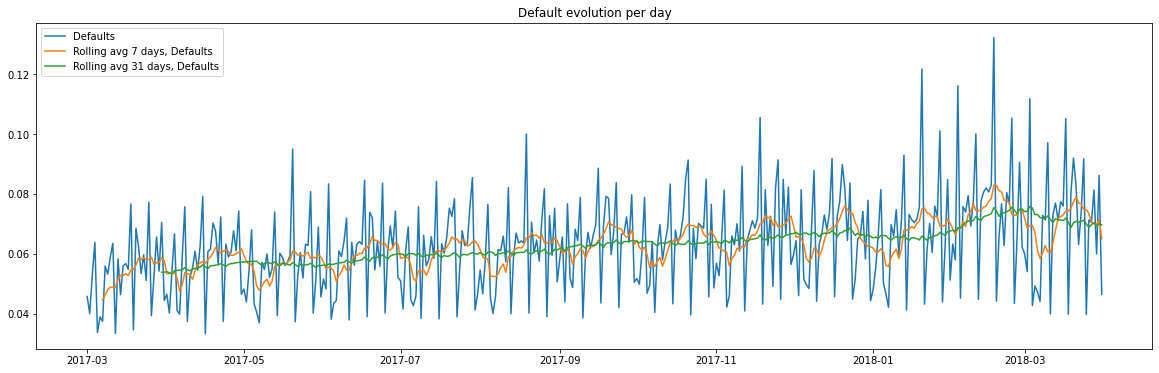

In [22]:
a = pd.DataFrame(train[["S_2","target"]].groupby(["S_2"])["target"].sum() *100 / len(train))
plt.figure(figsize = (20,6))
plt.plot(a, label = "Defaults")
plt.plot(a.rolling(7).mean(), label = "Rolling avg 7 days, Defaults")
plt.plot(a.rolling(30).mean(), label = "Rolling avg 31 days, Defaults")
plt.title("Default evolution per day")
plt.legend()
plt.show()
del a

We can see that the trend is increasing and we have a seasonal component.

#### Other features

##### NaN values

In [23]:
nansFeatPerc(train[s_features[1:]].columns)

,S_9,S_27,S_7,S_3,S_22,S_24,S_25,S_26,S_23
0,53.04,25.33,18.45,18.45,0.34,0.34,0.23,0.01,0.01


In [24]:
means = {"S_22": train["S_22"].mean(),
         "S_24": train["S_24"].mean(),
         "S_25": train["S_25"].mean(),
         "S_26": train["S_26"].mean(),
         "S_23": train["S_23"].mean()}
train[["S_22","S_24","S_25","S_26","S_23"]] = train[["S_22","S_24","S_25","S_26","S_23"]].fillna(means)
del means

In [25]:
train = missingSW(train,["S_9","S_27","S_7","S_3"])
del train["S_9"]
s_features.remove("S_9")

In [26]:
train = imputerLR(train , s_features[1:])

In [27]:
# std = train["S_9"].describe()
# train["S_9d"] = train["S_9"].apply(lambda x : "N" if str(x) == "nan" else "0" if x < std.loc["25%"] else "1" if x < std.loc["50%"] else "2" if x < std.loc["75%"] else "3")
# del std

##### Outliers

In [28]:
train[s_features[1:]].describe().T

,count,mean,std,min,25%,50%,75%,max
S_3,4510907.0,0.225845,0.193347,-6.271321e-01,0.127259,0.163908,0.258102,5.482888
S_5,5531451.0,0.088105,0.407405,8.168135e-09,0.005636,0.013521,0.071321,206.875275
S_6,5531451.0,0.244192,0.426600,2.541465e-09,0.003285,0.006573,0.009859,1.010000
S_7,4510907.0,0.223138,0.206303,-4.701318e-01,0.093729,0.139701,0.295459,3.948271
S_8,5531451.0,0.327600,0.303089,6.187214e-09,0.007645,0.321748,0.494937,1.231413
S_11,5531451.0,0.375334,0.191010,-1.999987e-01,0.282444,0.289731,0.448762,3.801432
S_12,5531451.0,0.240463,0.250719,-4.041090e-01,0.186898,0.190826,0.208876,175.331421
S_13,5531451.0,0.254672,0.296670,3.655658e-09,0.004895,0.009797,0.427720,1.010000
S_15,5531451.0,0.374791,0.195098,-2.999998e-01,0.207550,0.401843,0.504834,5.308959
S_16,5531451.0,0.050816,0.772487,5.083304e-09,0.002553,0.005104,0.007657,231.758942


In [29]:
s_featuresScaler = scaler(train, s_features[1:], "target")

100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


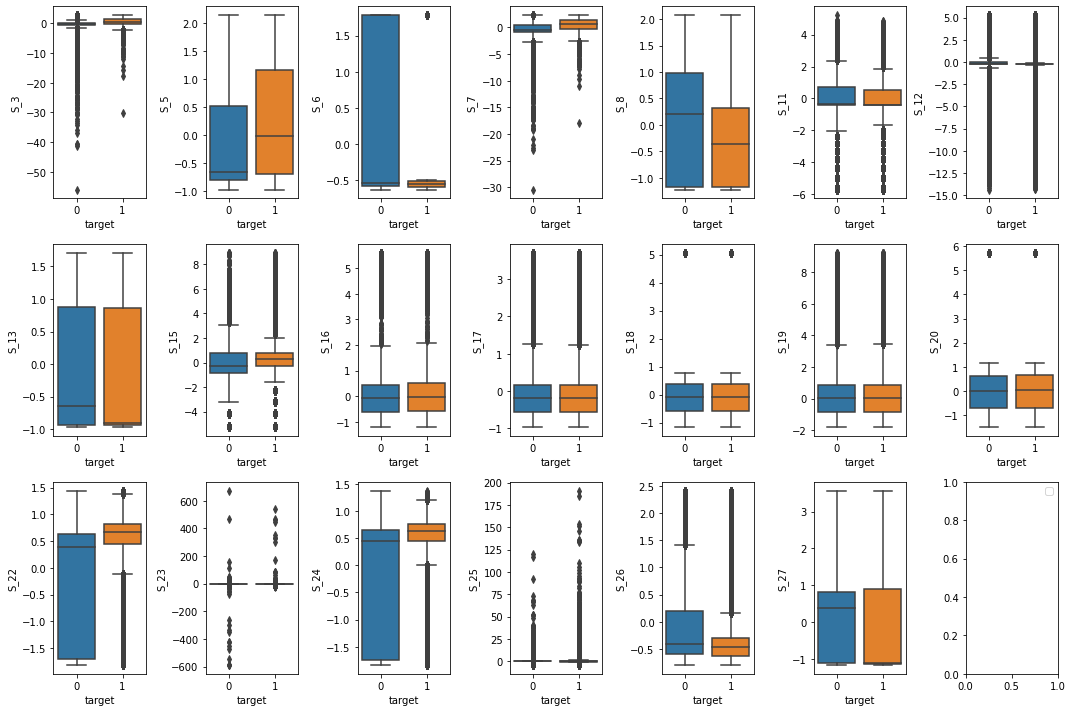

In [30]:
fig , axs = plt.subplots(3,7,figsize = (15,10))
ax = axs.ravel()
i = 0
for col in tqdm(s_features[1:]):
    sns.boxplot(x="target", y= col, data=s_featuresScaler[[col,"target"]] , ax = ax[i])
    i += 1
plt.tight_layout()
plt.legend()
plt.show()

### Delinquency features